Accuracy: 0.8304
Precision: 0.8095
Recall: 0.8595
R² Score: 0.4627
ROC AUC: 0.9170

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.80      0.83      2065
           1       0.81      0.86      0.83      2022

    accuracy                           0.83      4087
   macro avg       0.83      0.83      0.83      4087
weighted avg       0.83      0.83      0.83      4087



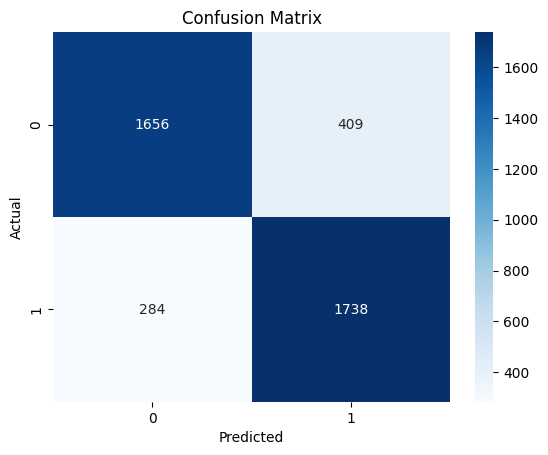

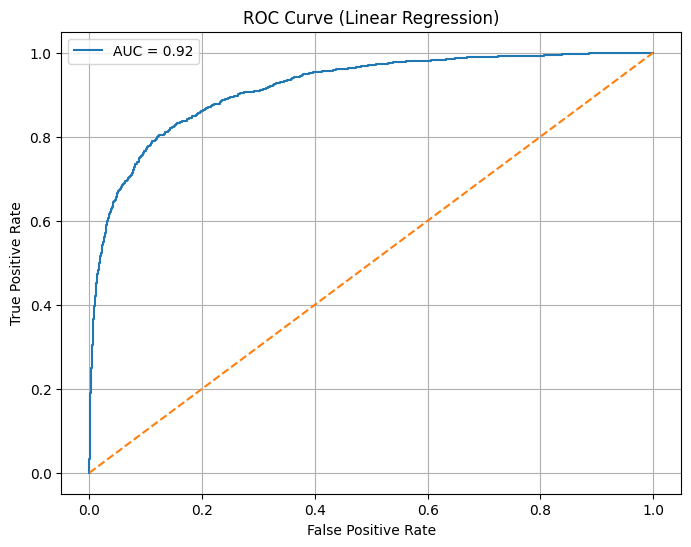

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    confusion_matrix, classification_report, roc_auc_score,
    roc_curve, r2_score
)
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv('/content/housing.csv')

# Binary target: 1 if house value > median, else 0
threshold = df['median_house_value'].median()
df['target'] = (df['median_house_value'] > threshold).astype(int)

# Drop original target column
df = df.drop(columns=['median_house_value'])

# Drop missing values
df = df.dropna()

# Features and target
X = df.drop(columns='target')
y = df['target']

# Column types
num_features = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
cat_features = X.select_dtypes(include=['object']).columns.tolist()

# Preprocessing
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])

# Linear Regression pipeline
model_pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('regressor', LinearRegression())
])

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit
model_pipeline.fit(X_train, y_train)

# Predict: continuous scores
y_pred_continuous = model_pipeline.predict(X_test)

# R² Score (on continuous predictions)
r2 = r2_score(y_test, y_pred_continuous)

# Convert to binary prediction using threshold
y_pred_binary = (y_pred_continuous >= 0.5).astype(int)

# Metrics
acc = accuracy_score(y_test, y_pred_binary)
prec = precision_score(y_test, y_pred_binary)
rec = recall_score(y_test, y_pred_binary)
roc_auc = roc_auc_score(y_test, y_pred_continuous)
cm = confusion_matrix(y_test, y_pred_binary)

# Print results
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"R² Score: {r2:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_binary))

# Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_continuous)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Linear Regression)")
plt.legend()
plt.grid(True)
plt.show()
